In [16]:
import numpy as np
import pandas as pd
import os
import pickle
import gc
import seaborn as sns

# 分布確認
#import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder

# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedGroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotlib で日本語表示したい場合
#!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [17]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_gender = pd.read_csv("./data/gender_submission.csv")
display(df_train.head())
display(df_test.head())
display(df_gender.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
#df_train = df_train.drop(columns=["PassengerId","Name","Ticket"])
df_train["Sex"].replace(["male","female"],[0,1],inplace=True)
display(df_train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,NaN,S
1,1,1,1,38.0,1,0,71.2833,C85,C
2,1,3,1,26.0,0,0,7.9250,NaN,S
3,1,1,1,35.0,1,0,53.1000,C123,S
4,0,3,0,35.0,0,0,8.0500,NaN,S


In [19]:
display(df_train.shape)
print("レコード数： ",len(df_train))
print("カラム数： ",len(df_train.columns))

(891, 9)

レコード数：  891
カラム数：  9


In [20]:
df_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [21]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
None


In [22]:
display(df_train.corr())

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [23]:
#df_trainをSurvivedの値で分ける
df_train_live = df_train[df_train["Survived"]==1]
df_train_dead = df_train[df_train["Survived"]==0]
display(df_train_live.head())
display(df_train_dead.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
8,1,3,female,27.0,0,2,11.1333,NaN,S
9,1,2,female,14.0,1,0,30.0708,NaN,C


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
5,0,3,male,NaN,0,0,8.4583,NaN,Q
6,0,1,male,54.0,0,0,51.8625,E46,S
7,0,3,male,2.0,3,1,21.0750,NaN,S


In [24]:
display(df_train_live.shape)
print("レコード数： ",len(df_train_live))
print("カラム数： ",len(df_train_live.columns))
display(df_train_dead.shape)
print("レコード数： ",len(df_train_dead))
print("カラム数： ",len(df_train_dead.columns))

(342, 9)

レコード数：  342
カラム数：  9


(549, 9)

レコード数：  549
カラム数：  9


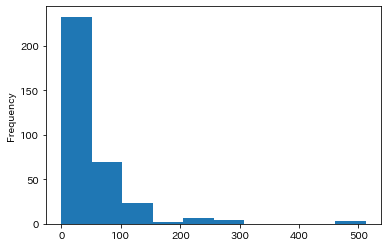

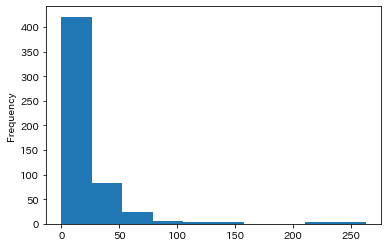

In [26]:
fare_var = df_train_live["Fare"]
fare_var.plot.hist()
plt.show()
fare_var = df_train_dead["Fare"]
fare_var.plot.hist()
plt.show()



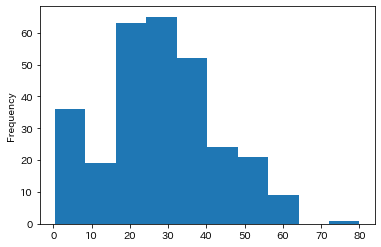

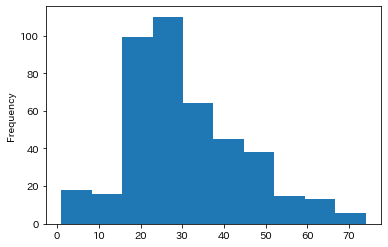

In [29]:
fare_var = df_train_live["Age"]
fare_var.plot.hist()
plt.show()
fare_var = df_train_dead["Age"]
fare_var.plot.hist()
plt.show()



In [30]:
print(df_train_dead.value_counts("Sex"))
print(df_train_live.value_counts("Sex"))

Sex
male      468
female     81
dtype: int64
Sex
female    233
male      109
dtype: int64


In [35]:
print(df_train_dead.value_counts("Cabin"))
print(df_train_live.value_counts("Cabin"))

Cabin
G6             2
D26            2
F G73          2
C23 C25 C27    2
C22 C26        2
              ..
C128           1
C2             1
C30            1
C46            1
T              1
Length: 62, dtype: int64
Cabin
B96 B98    4
F33        3
E101       3
G6         2
C126       2
          ..
C148       1
C123       1
C106       1
C104       1
C68        1
Length: 101, dtype: int64


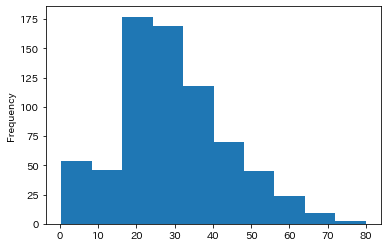

In [23]:
age_var = df_train["Age"]
age_var.plot.hist()
plt.show()


In [31]:
print(df_train_dead["Pclass"].value_counts())
print(df_train_live["Pclass"].value_counts())


3    372
2     97
1     80
Name: Pclass, dtype: int64
1    136
3    119
2     87
Name: Pclass, dtype: int64


In [32]:
print(df_train_dead["Parch"].value_counts())
print(df_train_live["Parch"].value_counts())


0    445
1     53
2     40
5      4
4      4
3      2
6      1
Name: Parch, dtype: int64
0    233
1     65
2     40
3      3
5      1
Name: Parch, dtype: int64


In [33]:
print(df_train_dead["Embarked"].value_counts())
print(df_train_live["Embarked"].value_counts())

S    427
C     75
Q     47
Name: Embarked, dtype: int64
S    217
C     93
Q     30
Name: Embarked, dtype: int64


In [34]:
print(df_train_dead["SibSp"].value_counts())
print(df_train_live["SibSp"].value_counts())

0    398
1     97
4     15
2     15
3     12
8      7
5      5
Name: SibSp, dtype: int64
0    210
1    112
2     13
3      4
4      3
Name: SibSp, dtype: int64


## データセットの作成

In [43]:
df_X = df_train[["Pclass","Sex","Fare"]]
df_y = df_train['Survived']
display(df_X.shape,df_y.shape)
display(df_X.head())
display(df_y.head())

(891, 3)

(891,)

,Pclass,Sex,Fare
0,3,0,7.2500
1,1,1,71.2833
2,3,1,7.9250
3,1,1,53.1000
4,3,0,8.0500


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## ホールドアウト検証の実行

In [44]:
X_train,X_test,y_train,y_test = train_test_split(df_X,df_y,test_size=0.2,shuffle=True,stratify=df_y,random_state=123)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(712, 3) (712,)
(179, 3) (179,)


## クロスバリデーションの実行

In [48]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

## モデル学習

In [51]:
y_pred = lr.predict(X_test)
accuracy_score(y_test,y_pred)

0.7821229050279329